In [2]:
import torch
from torch import nn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.encoder5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )


        # Decoder
        self.upconv_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, image):

        # Encoder
        e1 = self.encoder1(image)
        e2 = self.encoder2(self.max_pool_2x2(e1))
        e3 = self.encoder3(self.max_pool_2x2(e2))
        e4 = self.encoder4(self.max_pool_2x2(e3))
        e5 = self.encoder5(self.max_pool_2x2(e4))

        # Decoder
        d1 = self.upconv_1(e5)
        c1 = center_crop(e4, d1)
        d1 = torch.cat([d1, c1], dim=1)
        d1 = self.decoder1(d1)
        
        d2 = self.upconv_2(d1)
        c2 = center_crop(e3, d2)
        d2 = torch.cat([d2, c2], dim=1)
        d2 = self.decoder2(d2)

        d3 = self.upconv_3(d2)
        c3 = center_crop(e2, d3)
        d3 = torch.cat([d3, c3], dim=1)
        d3 = self.decoder3(d3)

        d4 = self.upconv_4(d3)
        c4 = center_crop(e1, d4)
        d4 = torch.cat([d4, c4], dim=1)
        d4 = self.decoder4(d4)

        # Final output
        out = self.final_conv(d4)

        return out

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, img_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir)) if mask_dir else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.mask_paths:
            mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
            mask = Image.open(mask_path).convert("L")

            if self.img_transform:
                image = self.img_transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, mask
        else:
            if self.img_transform:
                image = self.img_transform(image)
            return image

In [8]:
from torch.utils.data import DataLoader

# For images
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# For masks
mask_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),  # will keep it as float [0,1] with shape [1, H, W]
    T.Lambda(lambda x: (x > 0.5).float())  # binarize mask
])

train_dataset = CarvanaDataset(
    image_dir="train_images",
    mask_dir="train_masks",
    img_transform=img_transform,
    mask_transform=mask_transform
)

test_dataset = CarvanaDataset(
    image_dir="test",
    img_transform=img_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [10]:
model = UNet()  # Replace with your U-Net class
model.load_state_dict(torch.load('unet_model_new.pth'))  # Your saved model
model.eval().to(device)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=

In [11]:
def center_crop(encoder_feature, target_tensor):
    _, _, H, W = target_tensor.shape
    enc_H, enc_W = encoder_feature.shape[2], encoder_feature.shape[3]
    crop_H = (enc_H - H) // 2
    crop_W = (enc_W - W) // 2
    return encoder_feature[:, :, crop_H:crop_H+H, crop_W:crop_W+W]

In [13]:
# import torch
# import torchvision.transforms.functional as TF
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# # Load model
# model = UNet()
# model.load_state_dict(torch.load("unet_model_new.pth", map_location="cpu"))
# model.eval()
# model.to(device)

# # Create output folder
# os.makedirs("predicted_masks", exist_ok=True)

# # Inference loop
# with torch.no_grad():
#     for images, filenames in test_loader:
#         images = images.to(device)

#         outputs = model(images)
#         outputs = torch.sigmoid(outputs)               # Convert logits to probability
#         preds = (outputs > 0.5).float()                # Threshold to binary mask

#         pred_np = preds.squeeze().cpu().numpy()        # Remove batch and channel
#         pred_img = (pred_np * 255).astype(np.uint8)    # Convert to 0-255 image

#         # Save prediction
#         Image.fromarray(pred_img).save(f"predicted_masks/{filenames[0]}")


In [14]:
from torchvision import transforms
from PIL import Image

# Load image
image_path = "train_images/0cdf5b5d0ce1_16.jpg"
img = Image.open(image_path).convert("RGB")

# Define your transform (must match training!)
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # or your training size
#     transforms.ToTensor(),
# ])

# For images
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

In [18]:
with torch.no_grad():
    pred_mask = model(input_tensor)
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = pred_mask.squeeze().cpu().numpy()  # shape: (H, W)

In [22]:
# binary_mask = (pred_mask > 0.5).astype(np.uint8)

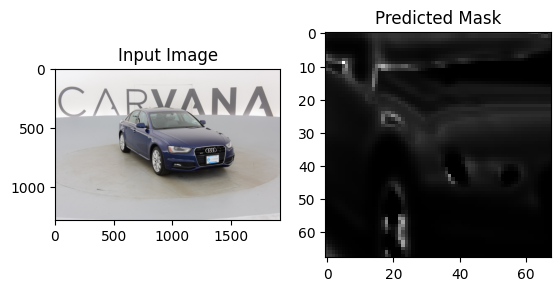

In [23]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [25]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torch.serialization import add_safe_globals
add_safe_globals([UNet])

# Load model
model = UNet()
model= torch.load('unet_model_new.pth', map_location="cpu", weights_only=False)
model.to(device)
model.eval()

# Load image
image_path = "train_images/0cdf5b5d0ce1_16.jpg"
img = Image.open(image_path).convert("RGB")

# Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Preprocess image
input_tensor = transform(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    pred_mask = model(input_tensor)
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = pred_mask.squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [55]:
mask = Image.open("train_masks/0cdf5b5d0ce1_01.png")
mask_np = np.array(mask)
print("Unique values in mask:", np.unique(mask_np))

Unique values in mask: [0 1]


In [56]:
mask = Image.open("train_images/0cdf5b5d0ce1_01.jpg")
mask_np = np.array(mask)
print("Unique values in image:", np.unique(mask_np))

Unique values in image: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 24

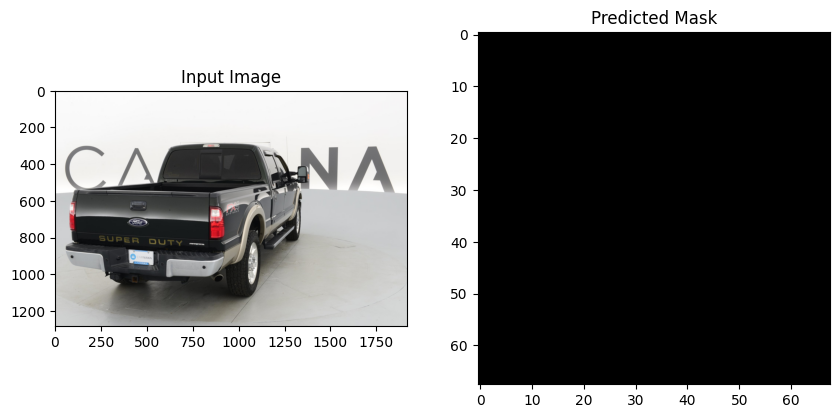

In [64]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess image
image_path = "train_images/0ed6904e1004_10.jpg"
img = Image.open(image_path).convert("RGB")  # Make sure it's 3-channel

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure same size as training
    transforms.ToTensor()
])

image_tensor = transform(img).unsqueeze(0)  # Add batch dimension: [1, 3, 256, 256]
image_tensor = image_tensor.to(device)

# Predict
model.eval()
with torch.no_grad():
    pred_mask = model(image_tensor)  # [1, 1, 256, 256]
    pred_mask = torch.sigmoid(pred_mask)  # Ensure output is in [0, 1]
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

# Threshold to binary mask
binary_mask = (pred_mask_np > -0.1).astype('uint8') * 255

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Mask")

plt.show()



In [65]:
print(pred_mask.min(), pred_mask.max())

tensor(0.0045, device='cuda:0') tensor(0.0045, device='cuda:0')


In [69]:
# Load and preprocess image
image_path = "train_images/0ed6904e1004_10.jpg"
img = Image.open(image_path).convert("RGB")  # Make sure it's 3-channel

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure same size as training
    transforms.ToTensor()
])

image_tensor = transform(img).unsqueeze(0)  # Add batch dimension: [1, 3, 256, 256]
image_tensor = image_tensor.to(device)


# Predict
model.eval()
with torch.no_grad():
    pred_mask = model(image_tensor)  # [1, 1, 256, 256]
    pred_mask = torch.sigmoid(pred_mask)  # Ensure output is in [0, 1]
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

In [70]:
print(pred_mask.min(), pred_mask.max())

tensor(0.0045, device='cuda:0') tensor(0.0045, device='cuda:0')


In [26]:
# Load and preprocess image
image_path = "train_images/0ed6904e1004_10.jpg"
img = Image.open(image_path).convert("RGB")  # Make sure it's 3-channel

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # mean
                         [0.229, 0.224, 0.225])  # std
])

image_tensor = transform(img).unsqueeze(0)  # Add batch dimension: [1, 3, 256, 256]
image_tensor = image_tensor.to(device)


# Predict
model.eval()
with torch.no_grad():
    pred_mask = model(image_tensor)  # [1, 1, 256, 256]
    pred_mask = torch.sigmoid(pred_mask)  # Ensure output is in [0, 1]
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [27]:
def visualize_predictions(model, dataloader, device, threshold=0.5, num_samples=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > threshold).float()

    for i in range(num_samples):
        img = TF.to_pil_image(images[i].cpu())
        mask = TF.to_pil_image(masks[i].cpu())
        pred = TF.to_pil_image(preds[i].cpu())

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred, cmap='gray')
        axs[2].set_title("Predicted Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
visualize_predictions(model, train_loader, device)